<a href="https://colab.research.google.com/github/nadhifaah/adulterant-detection-in-honey/blob/main/adulterant_detection_in_honey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import cv2 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import urllib.request

from google.colab.patches import cv2_imshow

# Data Citra

In [ ]:
url = 'https://www.dropbox.com/s/07141qjjh857xk1/lena.jpg?dl=1'
u = urllib.request.urlopen(url)
data = u.read()
u.close()

with open('image.jpg', "wb") as f :
    f.write(data)

In [ ]:
img = cv2.imread('/content/image.jpg')
rows, cols, _ = img.shape
print("Rows", rows)
print("Cols", cols)

Rows 512
Cols 512


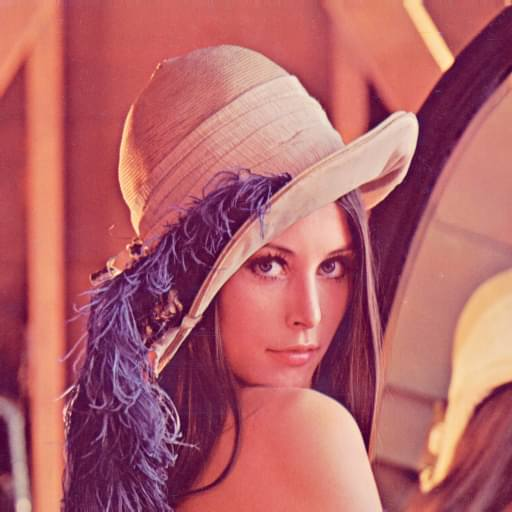

In [ ]:
# with jupyter please uncomment the following 
# cv2.imshow("image", img)
# cv2.waitKey(0)

# with google colab only 
cv2_imshow(img)

Cut Image

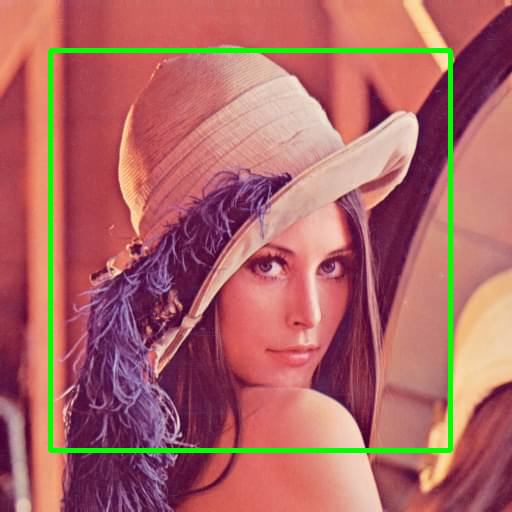

In [ ]:
cut_image = img[0:253, 0:323]

#Region of Interest (ROI)
# (x1, y1), (x2, y2), (R , G, B), 3
cv2.rectangle(img, (50,50), (450,450), (0,255,0), 3)
# roi = img[y1:y2, x1:x2]
roi = img[50:450, 50:450]
cv2_imshow(img)

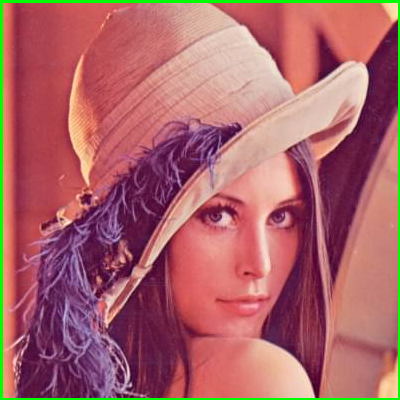

In [ ]:
cv2_imshow(roi)

### Image Histogram


```
# This is formatted as code
```



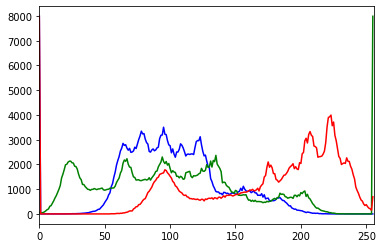

In [ ]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

### PCA (Principal Component Analysis)

Display the image

Data Standarization

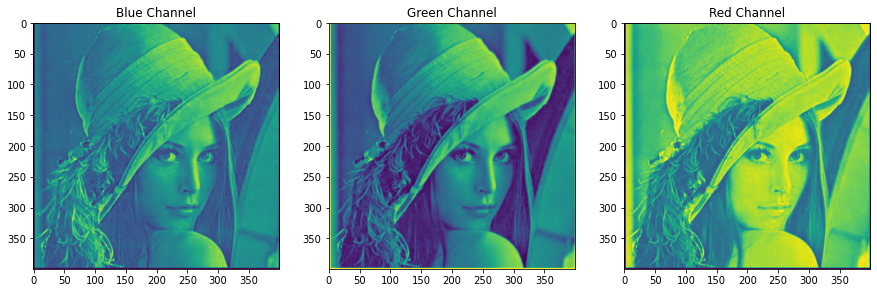

In [ ]:
from sklearn.decomposition import PCA
from scipy.stats import stats
import matplotlib.image as mpimg

#Splitting into channels
blue,green,red = cv2.split(roi)
# Plotting the images
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()

Verify data in blue channel

In [ ]:
blue_temp_df = pd.DataFrame(data = blue)
blue_temp_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,104,101,100,96,94,90,88,88,84,74,73,74,73,68,67,69,73,74,73,75,76,77,77,79,80,82,82,83,84,85,84,82,81,82,83,81,81,...,96,96,96,96,97,98,100,99,99,99,98,98,97,96,93,94,94,95,93,96,111,121,131,133,143,152,157,160,164,165,170,170,171,172,174,173,167,163,0,0
4,0,0,0,104,102,100,95,94,90,88,87,83,74,72,74,74,66,66,71,75,74,73,77,75,76,78,79,80,81,82,82,83,84,83,80,79,80,81,81,81,...,96,95,95,96,97,97,100,99,99,98,97,97,97,96,96,94,95,97,95,90,98,104,124,127,139,149,156,159,162,165,169,169,170,172,174,175,172,166,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,0,0,130,129,128,122,121,118,114,109,106,104,109,130,127,129,113,84,90,100,83,69,68,64,60,59,64,67,65,60,58,62,65,68,69,69,67,56,62,...,114,114,116,115,112,110,110,110,110,110,110,108,108,105,100,97,96,99,116,133,143,143,151,152,154,150,146,142,137,136,140,142,149,154,158,162,167,164,0,0
396,0,0,0,132,128,127,125,123,120,116,111,108,108,117,132,122,116,99,78,91,99,77,71,71,67,61,59,65,70,68,62,60,63,65,67,67,65,62,56,65,...,114,114,117,116,113,110,111,111,111,111,111,110,110,107,100,97,93,98,116,134,143,139,149,152,154,150,146,139,136,135,140,142,149,154,158,162,167,164,0,0
397,0,0,0,128,125,124,124,124,121,117,112,110,111,118,135,120,109,91,75,89,95,67,72,73,69,60,58,67,71,69,63,63,63,65,66,65,63,59,61,69,...,117,117,119,118,115,113,110,110,112,110,110,111,110,106,100,96,93,98,117,135,143,138,148,150,150,148,144,139,136,134,140,144,149,154,158,162,165,162,0,0
398,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


data normalization so that the value will be between 0 and 1 

In [ ]:
df_blue = blue/255
df_green = green/255
df_red = red/255

check the optimized value of principal component using elbow method

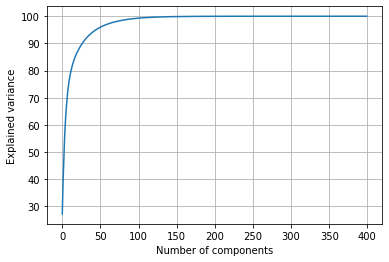

In [ ]:
pca_784 = PCA(n_components=400)
pca_784.fit(df_blue)
plt.grid()
plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('Scree plot.png')

transform and inverse the image 

In [ ]:
pca_b = PCA(n_components=50)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)

pca_g = PCA(n_components=50)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)

pca_r = PCA(n_components=50)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

In [ ]:
print(trans_pca_b.shape)
print(trans_pca_r.shape)
print(trans_pca_g.shape)

(400, 50)
(400, 50)
(400, 50)


In [ ]:
print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

Blue Channel : 0.9582738579150308
Green Channel: 0.9776384774033535
Red Channel  : 0.9780319747855538


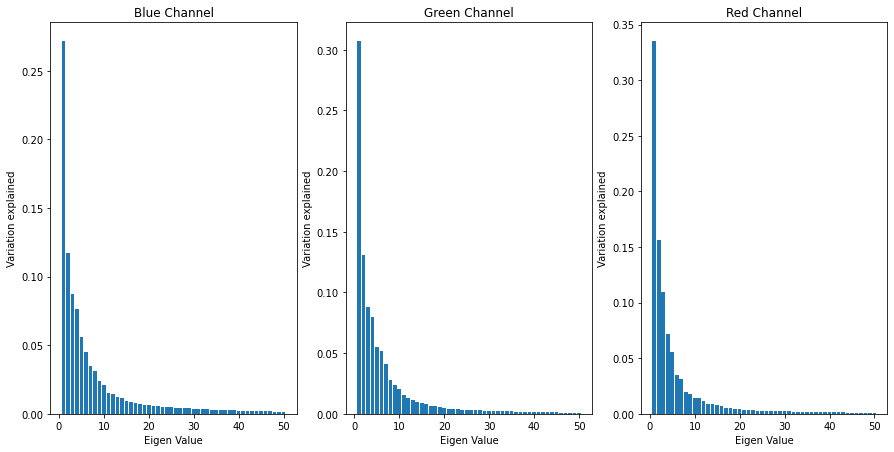

In [ ]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Blue Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_b.explained_variance_ratio_)
fig.add_subplot(132)
plt.title("Green Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_g.explained_variance_ratio_)
fig.add_subplot(133)
plt.title("Red Channel")
plt.ylabel('Variation explained')
plt.xlabel('Eigen Value')
plt.bar(list(range(1,51)),pca_r.explained_variance_ratio_)
plt.show()

In [ ]:
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(400, 400) (400, 400) (400, 400)


In [ ]:
# img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
img_reduced= (cv2.merge((r_arr, g_arr, b_arr)))
print(img_reduced.shape)

(400, 400, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


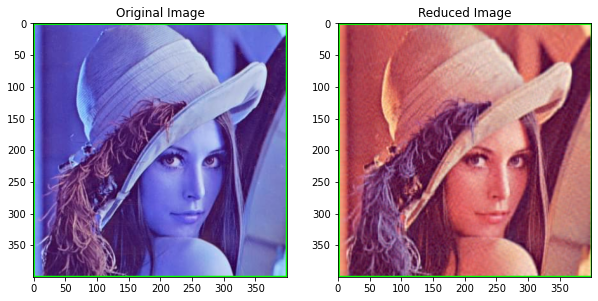

In [ ]:
fig = plt.figure(figsize = (10, 7.2)) 
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(roi)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()

### LDA (Linear Discriminant Analysis)

# Data Spectroscopy

In [ ]:
path_em_1 = '/content/drive/MyDrive/Data Fluoresensi Mas Fahri/Data Standart Kafein/kafein/0/em 1.txt'

In [ ]:
df_em_1 = pd.read_csv(path_em_1, delimiter = "\t", header=None)
df_em_1 = df_em_1.stack().str.replace(',','.').unstack()
df_em_1

,0,1
0,200.00,0.4770
1,200.50,0.4432
2,201.00,0.4295
3,201.50,0.4093
4,202.00,0.3787
...,...,...
1196,798.00,0.6792
1197,798.50,0.6787
1198,799.00,0.6003
1199,799.50,0.4789


In [ ]:
df_em_1 = df_em_1.rename(columns={0: 'wavelength', 1: 'intensity'})

In [ ]:
df_em_1

,wavelength,intensity
0,200.00,0.4770
1,200.50,0.4432
2,201.00,0.4295
3,201.50,0.4093
4,202.00,0.3787
...,...,...
1196,798.00,0.6792
1197,798.50,0.6787
1198,799.00,0.6003
1199,799.50,0.4789


In [ ]:
df_em_1['wavelength'] = df_em_1.wavelength.astype(float)
df_em_1['intensity'] = df_em_1.intensity.astype(float)

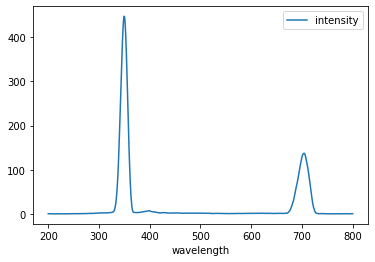

In [ ]:
df_em_1.plot(x="wavelength",y="intensity")

In [ ]:
ttest_rel(df_em_1['wavelength'], df_em_1['intensity'])

Ttest_relResult(statistic=88.2090859021322, pvalue=0.0)

# All Features 